# Planar Data Classification with One Hidden Layer

Planar data classification poses a unique challenge when decision boundaries are non-linear. Traditional linear classifiers like logistic regression often fall short in accurately categorizing such data. This exercise explores the use of a neural network with a single hidden layer to capture the complex relationships in planar data. Utilizing a tanh activation function for the hidden layer and computing the cross-entropy loss, the neural network aims to create a more accurate and nuanced classification model.

In [2]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, load_planar_dataset, load_extra_datasets

%matplotlib inline

In [3]:
X, Y = load_planar_dataset()

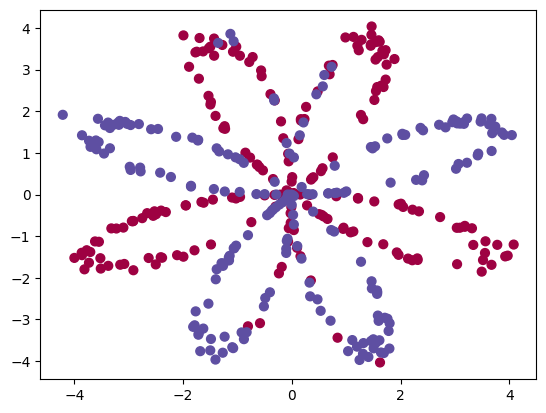

In [7]:
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral)

## Understanding the Data
The data is generated in such a way that it forms a flower-like structure when plotted, with two different classes (Red and Blue). Traditional linear classifiers often struggle with such non-linearly separable data. The goal is to build a model to fit this data. In other words, we want the classifier to define regions as either red or blue.

## Features and Labels

- $X$ is a matrix where each column represents a single example with two features. Specifically, $x_1$ and $x_2$ denote the coordinates in a 2D plane.
  - $x_1$ corresponds to the horizontal coordinate.
  - $x_2$ corresponds to the vertical coordinate.
  
- $Y$ is a row vector containing the labels for each example in $X$. The labels are either 0 or 1, representing two classes.
  - Red is represented by a label of 0.
  - Blue is represented by a label of 1.

In [10]:
shape_X, shape_Y = X.shape, Y.shape

print(f'The shape of X is: {shape_X}')
print(f'The shape of Y is: {shape_Y}')

The shape of X is: (2, 400)
The shape of Y is: (1, 400)


In [11]:
m = shape_X[1]
print(f'I have m = {m} training examples!')

I have m = 400 training examples!


## Simple Logistic Regression

Before building a full neural network, let's check how logistic regression performs on this problem.

In [16]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X.T, Y.reshape(m,))

LogisticRegressionCV()

Accuracy of logistic regression: 47.0% (percentage of correctly labelled datapoints)


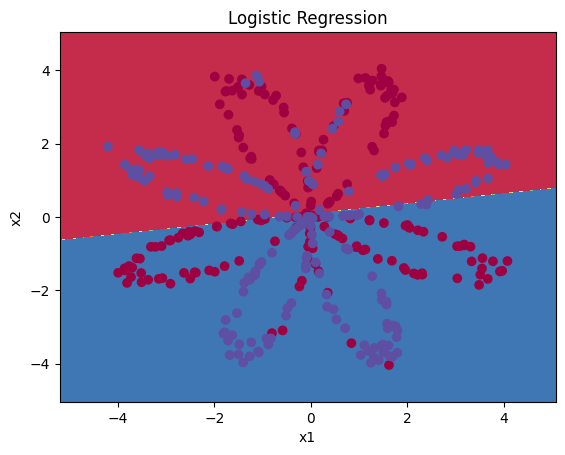

In [17]:
# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Logistic Regression")

# Print accuracy
LR_predictions = clf.predict(X.T)
acc = float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100)
print(f"Accuracy of logistic regression: {acc}% (percentage of correctly labelled datapoints)")

**Interpretation**: The dataset is not linearly separable, so logistic regression doesn't perform well. Hopefully a neural network will do better.

## Neural Network Model
Logistic regression didn't perform well on the flower dataset. Let's build a simple NN with one hidden layer.

For one example $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

Given the predictions on all the examples, we can compute the cost $J$ as follows: 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

In [18]:
def layer_sizes(X, Y):
    """
    Args:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    n_x = X.shape[0]    # 2 since X.shape = (2, 400)
    n_h = 4             # hardcoded here
    n_y = Y.shape[0]    # 1 since Y.shape = (1, 400)
    return (n_x, n_h, n_y)

In [19]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Args:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """    
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

### Forward Propagation
Recall that the equations for forward prop are given as:

$$Z^{[1]} =  W^{[1]} X + b^{[1]}\tag{1}$$ 
$$A^{[1]} = \tanh(Z^{[1]})\tag{2}$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}\tag{3}$$
$$\hat{Y} = A^{[2]} = \sigma(Z^{[2]})\tag{4}$$

In [30]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [31]:
def forward_propagation(X, parameters):
    """
    Args:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing parameters (W1, b1, W2, b2)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

### Compute the Cost

Now that we've computed $A^{[2]}$ (in the Python variable "`A2`"), which contains $a^{[2](i)}$ for all examples, we can compute the cost function as follows:

$$J = - \frac{1}{m} \sum\limits_{i = 1}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{13}$$

In [32]:
def compute_cost(A2, Y):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Args:
    A2 -- The sigmoid output of the second activation, of shape (1, m)
    Y -- "true" labels vector of shape (1, m)

    Returns:
    cost -- cross-entropy cost given equation (13)
    """
    
    m = Y.shape[1] # number of examples

    logprobs = np.multiply(np.log(A2), Y) + (1 - Y) * np.log(1 - A2)
    cost = -1/m * np.sum(logprobs)
    
    cost = float(np.squeeze(cost))  # turns [[17]] into 17 
    return cost

### Backward Propagation
Recall that the equations for backward prop are given as:

$$dZ^{[2]} = A^{[2]} - Y$$
$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[2]^{T}}$$
$$db^{[2]} = \frac{1}{m} np.sum(dZ^{[2]}, axis=1, keepdims=True)$$
$$dZ^{[1]} = W^{[2]T} dZ^{[2]} * g^{[1]'} (Z^{[1]})$$
$$dW^{[1]} = \frac{1}{m} dZ^{[1]} X^{T}$$
$$db^{[1]} = \frac{1}{m} np.sum(dZ^{[1]}, axis=1, keepdims=True)$$

In [33]:
def backward_propagation(parameters, cache, X, Y):
    """  
    Args:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    A1 = cache["A1"]
    A2 = cache["A2"]

    dZ2 = A2 - Y
    dW2 = 1/m * np.dot(dZ2, A1.T)
    db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = W2.T * dZ2 * (1 - np.power(A1, 2))
    dW1 = 1/m * np.dot(dZ1, X.T)
    db1 = 1/m * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [34]:
def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule.
    
    Args:
    parameters -- python dictionary containing parameters 
    grads -- python dictionary containing gradients 
    
    Returns:
    parameters -- python dictionary containing updated parameters 
    """

    W1 = copy.deepcopy(parameters["W1"])
    b1 = parameters["b1"]
    W2 = copy.deepcopy(parameters["W2"])
    b2 = parameters["b2"]

    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    W1 = W1 - learning_rate*dW1
    b1 = b1 - learning_rate*db1
    W2 = W2 - learning_rate*dW2
    b2 = b2 - learning_rate*db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

## Model Integration
Integrate the different parts of the model into a single function `nn_model()`.

In [50]:
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Args:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]

    parameters = initialize_parameters(n_x, n_h, n_y)

    for i in range(0, num_iterations):
        A2, cache = forward_propagation(X, parameters)
        cost = compute_cost(A2, Y)
        grads = backward_propagation(parameters, cache, X, Y)
        parameters = update_parameters(parameters, grads)
        
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print(f"Cost after iteration {i} : {cost:.5f}")

    return parameters

## Predictions
$y_{prediction} = \begin{cases}
      1 & \text{if}\ activation > 0.5 \\
      0 & \text{otherwise}
    \end{cases}$  

In [51]:
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Args:
    parameters -- python dictionary containing parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    A2, cache = forward_propagation(X, parameters)
    predictions = np.where(A2 > 0.5, 1, 0)
    
    return predictions

## Test the Model
It's time to run the model and see how it performs on a planar dataset.

Cost after iteration 0 : 0.69316
Cost after iteration 1000 : 0.25863
Cost after iteration 2000 : 0.23933
Cost after iteration 3000 : 0.23080
Cost after iteration 4000 : 0.22553
Cost after iteration 5000 : 0.22184
Cost after iteration 6000 : 0.21909
Cost after iteration 7000 : 0.22060
Cost after iteration 8000 : 0.21941
Cost after iteration 9000 : 0.21852


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

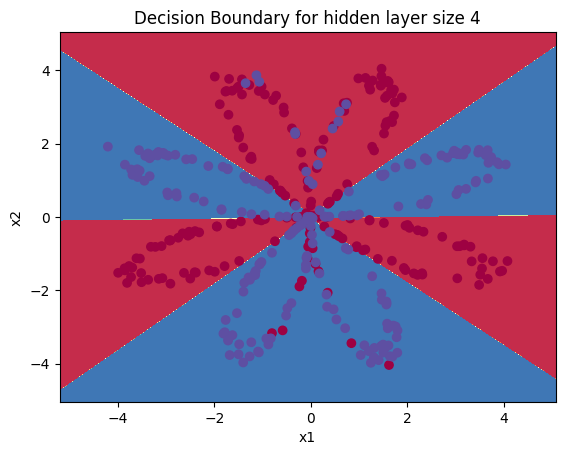

In [52]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h=4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

In [53]:
# Print accuracy
predictions = predict(parameters, X)
acc = float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100)
print(f'Accuracy: {acc}%')

Accuracy: 90.5%


## Tuning hidden layer size

Observe different behaviors of the model for various hidden layer sizes.

Accuracy for 1 hidden units: 67.5
Accuracy for 2 hidden units: 67.25
Accuracy for 3 hidden units: 90.75
Accuracy for 4 hidden units: 90.5
Accuracy for 5 hidden units: 91.25
Accuracy for 10 hidden units: 91.25
Accuracy for 20 hidden units: 90.75


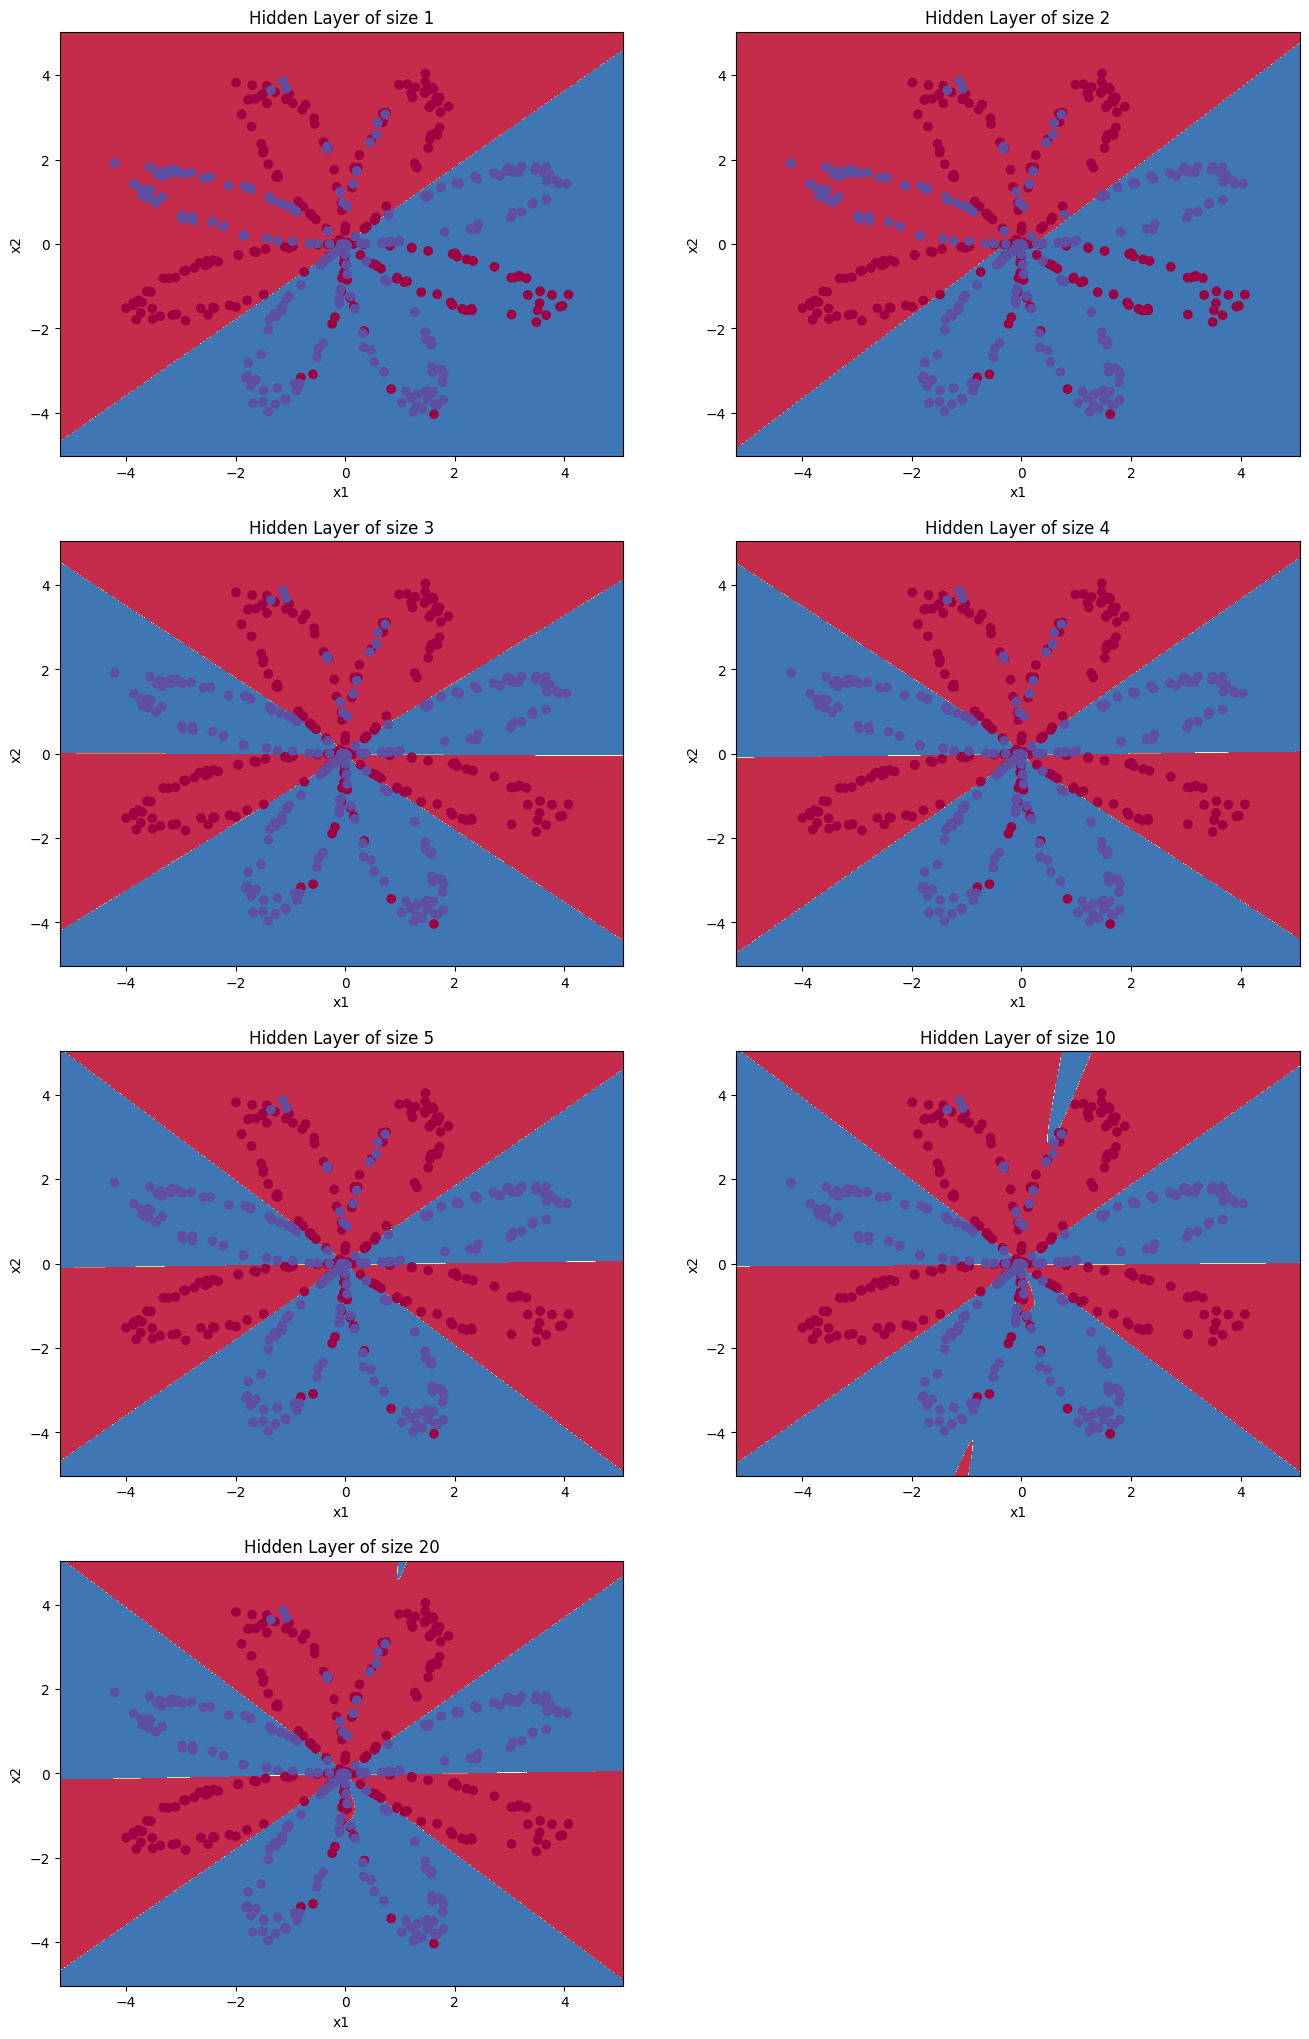

In [54]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 10, 20]

for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title(f'Hidden Layer of size {n_h}')
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size)*100)
    print(f"Accuracy for {n_h} hidden units: {accuracy}")

## Performance on other datasets

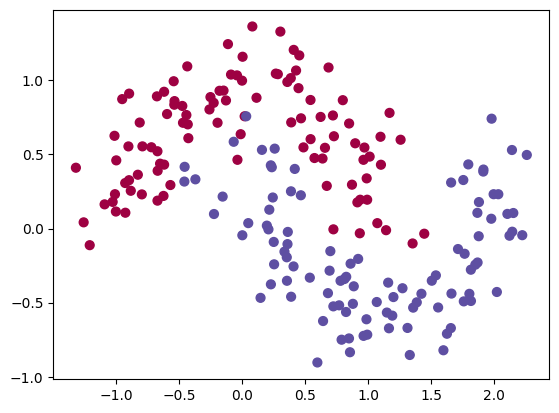

In [55]:
# Datasets
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

dataset = "noisy_moons"

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# make blobs binary
if dataset == "blobs":
    Y = Y%2

# Visualize the data
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

Cost after iteration 0 : 0.69316
Cost after iteration 1000 : 0.30440
Cost after iteration 2000 : 0.07894
Cost after iteration 3000 : 0.07063
Cost after iteration 4000 : 0.06850
Cost after iteration 5000 : 0.06733
Cost after iteration 6000 : 0.06648
Cost after iteration 7000 : 0.06564
Cost after iteration 8000 : 0.06253
Cost after iteration 9000 : 0.05680
Accuracy: 97.5%


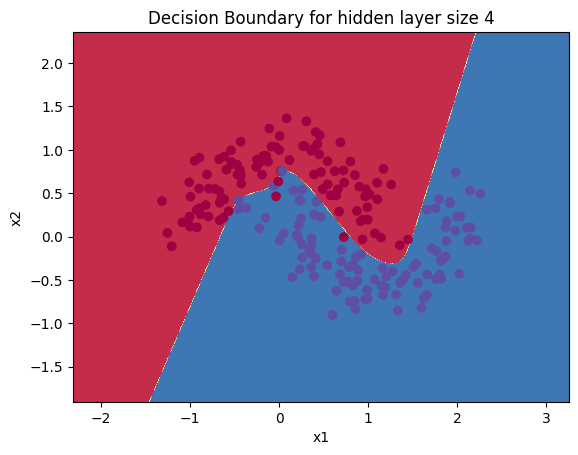

In [57]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h=4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))
predictions = predict(parameters, X)
acc = float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100)
print(f'Accuracy: {acc}%')

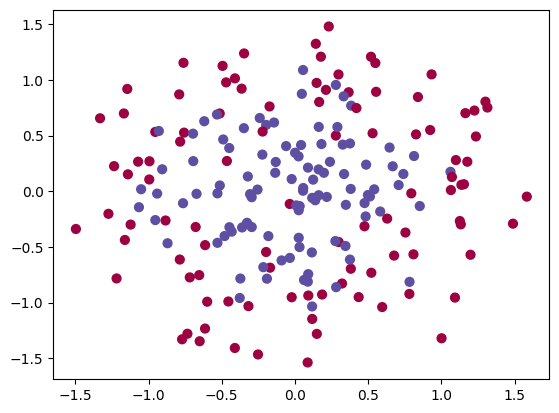

In [58]:
dataset = "noisy_circles"

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# make blobs binary
if dataset == "blobs":
    Y = Y%2

# Visualize the data
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

Cost after iteration 0 : 0.69315
Cost after iteration 1000 : 0.39696
Cost after iteration 2000 : 0.38507
Cost after iteration 3000 : 0.38822
Cost after iteration 4000 : 0.38826
Cost after iteration 5000 : 0.38829
Cost after iteration 6000 : 0.38830
Cost after iteration 7000 : 0.38826
Cost after iteration 8000 : 0.38810
Cost after iteration 9000 : 0.38802
Accuracy: 82.5%


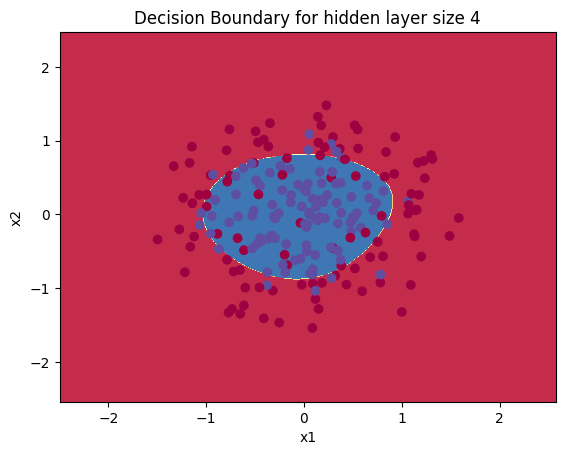

In [59]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h=4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))
predictions = predict(parameters, X)
acc = float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100)
print(f'Accuracy: {acc}%')

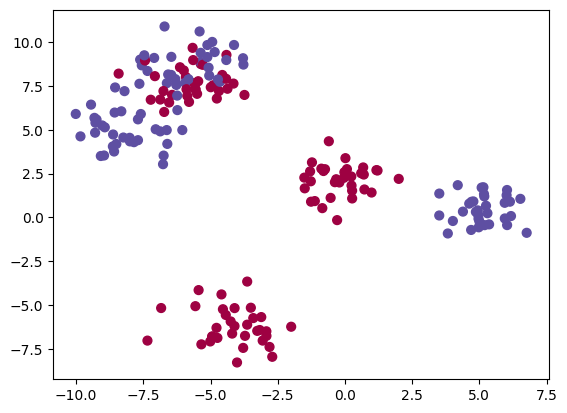

In [60]:
dataset = "blobs"

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# make blobs binary
if dataset == "blobs":
    Y = Y%2

# Visualize the data
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

Cost after iteration 0 : 0.69308
Cost after iteration 1000 : 0.32312
Cost after iteration 2000 : 0.32300
Cost after iteration 3000 : 0.32283
Cost after iteration 4000 : 0.32277
Cost after iteration 5000 : 0.32275
Cost after iteration 6000 : 0.32270
Cost after iteration 7000 : 0.32268
Cost after iteration 8000 : 0.32264
Cost after iteration 9000 : 0.32266
Accuracy: 83.0%


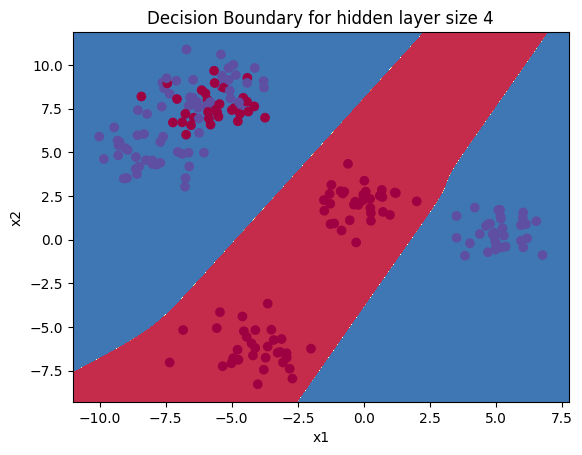

In [61]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h=4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))
predictions = predict(parameters, X)
acc = float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100)
print(f'Accuracy: {acc}%')

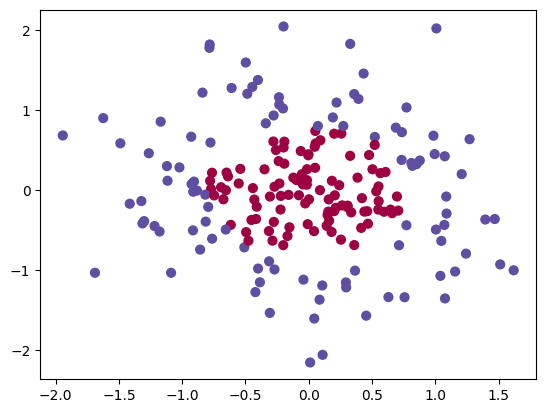

In [62]:
dataset = "gaussian_quantiles"

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# make blobs binary
if dataset == "blobs":
    Y = Y%2

# Visualize the data
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

Cost after iteration 0 : 0.69315
Cost after iteration 1000 : 0.10573
Cost after iteration 2000 : 0.09805
Cost after iteration 3000 : 0.08416
Cost after iteration 4000 : 0.08002
Cost after iteration 5000 : 0.07675
Cost after iteration 6000 : 0.07369
Cost after iteration 7000 : 0.07006
Cost after iteration 8000 : 0.06611
Cost after iteration 9000 : 0.06340


C:\Users\izhar\AppData\Local\Temp\ipykernel_7216\1847607923.py:15: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(np.log(A2), Y) + (1 - Y) * np.log(1 - A2)
C:\Users\izhar\AppData\Local\Temp\ipykernel_7216\1847607923.py:15: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(np.log(A2), Y) + (1 - Y) * np.log(1 - A2)


Accuracy: 98.0%


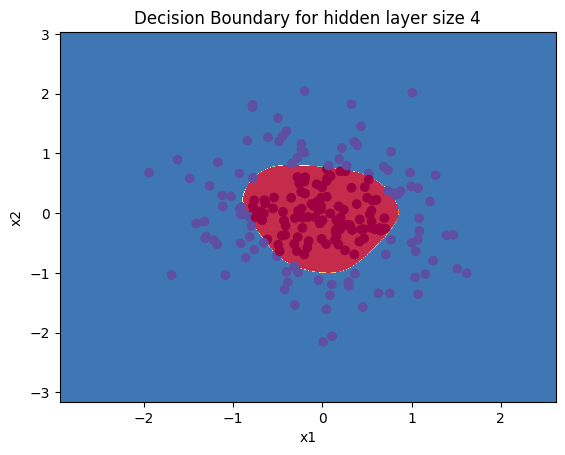

In [63]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h=4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))
predictions = predict(parameters, X)
acc = float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100)
print(f'Accuracy: {acc}%')